In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

In [4]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data

In [5]:
# find gpu
cuda = torch.cuda.is_available()

In [6]:
# hyperparameters
NUM_LEVELS = 4
tau = 1.
SEED = 1

In [7]:
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

In [8]:
#transform
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x>0.5,
        lambda x: x.float(),
    ])

In [9]:
# dataset loading
bsize = 100
train_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=True, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=False, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)

In [10]:
def sample_binary_concrete(inputs, temperature = tau):
    U = Variable(torch.rand(inputs.shape), requires_grad=False)
    if cuda:
        U = U.cuda()
    return F.sigmoid((U.log() - (1-U).log() + inputs)/temperature)

def hard_sample_binary_concrete(inputs):
    y = sample_binary_concrete(inputs)
    y_hard = torch.round(y)
    return (y_hard - y).detach() + y

In [11]:
class Encoder(nn.Module):
    def __init__(self, num_levels=NUM_LEVELS):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 64)
        
        # TODO try to make tunnels smaller as we go higher.
        self.tunnels = nn.ModuleList([nn.Linear(64,64) for _ in range(num_levels-1)])
        self.codings = nn.ModuleList([nn.Linear(64,2**(_)) for _ in range(num_levels-1, -1, -1)])   
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        sofar = self.relu(self.fc2(self.relu(self.fc1(x))))
        posteriors = [self.codings[0](sofar)]
        for _ in range(len(self.tunnels)):
            sofar = self.relu(self.tunnels[_](sofar))
            posteriors.append(self.codings[_+1](sofar))
        return posteriors
    
e = Encoder()
_, (data, _) = next(enumerate(train_loader))
data = data.view(-1, 784)
data = Variable(data, requires_grad=False)
if cuda:
    data = data.cuda()
    e.cuda()
post = e(data)
print(len(post))
print(post[0].shape)
print(post[1].shape)
print(post[2].shape)
print(post[3].shape)

4
torch.Size([100, 8])
torch.Size([100, 4])
torch.Size([100, 2])
torch.Size([100, 1])


In [12]:
class Decoder(nn.Module):
    def __init__(self, num_levels=NUM_LEVELS):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(2**(num_levels-1), 64)
        self.fc2 = nn.Linear(64,256)
        self.fc3 = nn.Linear(256,784)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, code):
        h = self.relu(self.fc1(code))
        h = self.relu(self.fc2(h))
        y = self.sigmoid(self.fc3(h))
        return y
    
d = Decoder()
if cuda:
    d.cuda()
d(post[0]).shape

torch.Size([100, 784])

In [13]:
class Hierarchy(nn.Module):
    def __init__(self, num_levels=NUM_LEVELS):
        super(Hierarchy, self).__init__()
        self.root_dist = Variable(torch.Tensor([0.5]))
        if cuda:
            self.root_dist = self.root_dist.cuda()
        self.downwards = nn.ModuleList([nn.Linear(2**(_-1),2**_) for _ in range(num_levels-1, 0, -1)])
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, codes):
        n_codes = len(codes)
        cond_priors = [self.root_dist.expand(codes[n_codes-1].size()[0],1)]
        # codes are 8, 4, 2, 1, so are downwards
        for i in range(n_codes-1, 0, -1):
            cond_priors.append(self.sigmoid(self.downwards[i-1](codes[i])))
        return cond_priors

h = Hierarchy()
if h:
    h.cuda()
print(h.downwards)
codes = [hard_sample_binary_concrete(posterior) for posterior in post]
prior = h(codes)
print(len(prior))
print(prior[0].shape)
print(prior[1].shape)
print(prior[2].shape)
print(prior[3].shape)

ModuleList(
  (0): Linear(in_features=4, out_features=8, bias=True)
  (1): Linear(in_features=2, out_features=4, bias=True)
  (2): Linear(in_features=1, out_features=2, bias=True)
)
4
torch.Size([100, 1])
torch.Size([100, 2])
torch.Size([100, 4])
torch.Size([100, 8])


In [14]:
class Model(nn.Module):
    def __init__(self, num_levels=NUM_LEVELS):
        super(Model, self).__init__()
        self.E = Encoder(num_levels)
        self.D = Decoder(num_levels)
        self.H = Hierarchy(num_levels)
        
    def forward(self, x):
        posteriors = self.E(x)
        codes = [hard_sample_binary_concrete(posterior) for posterior in posteriors]
        cond_priors = self.H(codes)
        y = self.D(codes[0])
        cond_priors.reverse() # to make it the same shape as posteriors
        return cond_priors, posteriors, y
        
    def generate(self):
        # TODO
        pass
    
    def save(self):
        torch.save(self.state_dict(), 'generative_mnist_U_shaped.save')
        
    def load(self):
        self.load_state_dict(torch.load('generative_mnist_U_shaped.save'))
    
m = Model()
_, (data, _) = next(enumerate(train_loader))
data = data.view(-1, 784)
data = Variable(data, requires_grad=False)
if cuda:
    m.cuda()
    data = data.cuda()
cond_priors, posteriors, y = m(data)
# assert they're of the same shape order, to prevent stupid mistake in KLD
assert cond_priors[0].shape == posteriors[0].shape

In [15]:
def KLD(cond_priors, posteriors):
    cond_priors = torch.cat(cond_priors, dim = -1)
    posteriors = torch.cat(posteriors, dim = -1) 
    posteriors = F.sigmoid(posteriors)
    const = 1E-20
    kld_per_latent = posteriors * ((posteriors+const).log() - (cond_priors+const).log()) + \
                    (1-posteriors) * ((1-posteriors+const).log() - (1-cond_priors+const).log())
    return kld_per_latent.sum(dim=-1).mean()

def recon_loss(y, true_y):
    return F.binary_cross_entropy(y, true_y, size_average=False)/y.size()[0]

In [16]:
model = Model()
if cuda:
    model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=1e-3)
best_loss = 9999999

In [17]:
def train(epoch):
    global best_loss
    train_loss = 0
    kld_loss = 0
    rec_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        data = Variable(data, requires_grad=False)
        if cuda:
            data = data.cuda()
        x = data.view(-1,784)
        
        cond_priors, posteriors, y = model(x)
        
        kld = KLD(cond_priors, posteriors)
        rec = recon_loss(y, x)
        loss = kld + rec
        
        loss.backward()
        optimizer.step()
        train_loss += loss.data[0]
        kld_loss += kld.data[0]
        rec_loss += rec.data[0]
        
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tKLD: {:.6f}\trecon_loss:{:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                batch_idx*100/ len(train_loader),
                loss.data[0], kld.data[0], rec.data[0]))
    print('====> Epoch: {} Average loss: {:.4f}\tKLD: {:.6f}\trecon_loss:{:.6f}'.format(
          epoch+1, train_loss / len(train_loader), kld_loss/ len(train_loader), rec_loss/ len(train_loader)))
    
    cur_loss = train_loss / len(train_loader)
    if cur_loss < best_loss:
        model.save()
        best_loss = cur_loss

In [18]:
%%time
train(0)

Train Epoch: 1 [0/60000 (0%)]	Loss: 544.737915	KLD: 0.551241	recon_loss:544.186646
Train Epoch: 1 [10000/60000 (17%)]	Loss: 205.555359	KLD: 3.165781	recon_loss:202.389572
Train Epoch: 1 [20000/60000 (33%)]	Loss: 198.766342	KLD: 2.268629	recon_loss:196.497711
Train Epoch: 1 [30000/60000 (50%)]	Loss: 196.553894	KLD: 1.682071	recon_loss:194.871826
Train Epoch: 1 [40000/60000 (67%)]	Loss: 186.619400	KLD: 1.537798	recon_loss:185.081604
Train Epoch: 1 [50000/60000 (83%)]	Loss: 185.351547	KLD: 1.455102	recon_loss:183.896439
====> Epoch: 1 Average loss: 201.0512	KLD: 2.082203	recon_loss:198.968987
CPU times: user 10.6 s, sys: 412 ms, total: 11 s
Wall time: 11 s


In [19]:
# training
epochs = 25
for epoch in range(1,epochs):
    train(epoch)

Train Epoch: 2 [0/60000 (0%)]	Loss: 186.492691	KLD: 1.457921	recon_loss:185.034775
Train Epoch: 2 [10000/60000 (17%)]	Loss: 193.879730	KLD: 1.150125	recon_loss:192.729599
Train Epoch: 2 [20000/60000 (33%)]	Loss: 184.803085	KLD: 1.385548	recon_loss:183.417542
Train Epoch: 2 [30000/60000 (50%)]	Loss: 190.398605	KLD: 1.344391	recon_loss:189.054214
Train Epoch: 2 [40000/60000 (67%)]	Loss: 197.343216	KLD: 1.147183	recon_loss:196.196030
Train Epoch: 2 [50000/60000 (83%)]	Loss: 175.005417	KLD: 1.551585	recon_loss:173.453827
====> Epoch: 2 Average loss: 188.5713	KLD: 1.315119	recon_loss:187.256190
Train Epoch: 3 [0/60000 (0%)]	Loss: 195.627670	KLD: 1.339826	recon_loss:194.287842
Train Epoch: 3 [10000/60000 (17%)]	Loss: 187.469238	KLD: 2.140260	recon_loss:185.328979
Train Epoch: 3 [20000/60000 (33%)]	Loss: 181.989136	KLD: 1.734797	recon_loss:180.254333
Train Epoch: 3 [30000/60000 (50%)]	Loss: 176.179016	KLD: 2.098696	recon_loss:174.080322
Train Epoch: 3 [40000/60000 (67%)]	Loss: 183.677200	KLD:

Train Epoch: 15 [50000/60000 (83%)]	Loss: 178.529388	KLD: 1.567015	recon_loss:176.962372
====> Epoch: 15 Average loss: 180.1606	KLD: 1.690445	recon_loss:178.470158
Train Epoch: 16 [0/60000 (0%)]	Loss: 192.700806	KLD: 1.368126	recon_loss:191.332687
Train Epoch: 16 [10000/60000 (17%)]	Loss: 184.310699	KLD: 1.345775	recon_loss:182.964920
Train Epoch: 16 [20000/60000 (33%)]	Loss: 183.717300	KLD: 1.369588	recon_loss:182.347717
Train Epoch: 16 [30000/60000 (50%)]	Loss: 186.329727	KLD: 1.456652	recon_loss:184.873077
Train Epoch: 16 [40000/60000 (67%)]	Loss: 181.251160	KLD: 1.413481	recon_loss:179.837677
Train Epoch: 16 [50000/60000 (83%)]	Loss: 174.184616	KLD: 1.480698	recon_loss:172.703918
====> Epoch: 16 Average loss: 184.2437	KLD: 1.441967	recon_loss:182.801725
Train Epoch: 17 [0/60000 (0%)]	Loss: 187.286392	KLD: 1.375855	recon_loss:185.910538
Train Epoch: 17 [10000/60000 (17%)]	Loss: 194.386597	KLD: 1.157508	recon_loss:193.229095
Train Epoch: 17 [20000/60000 (33%)]	Loss: 192.023834	KLD: 1

In [20]:
print("Loading best model with loss {}".format(best_loss))
model.load()

Loading best model with loss 165.42111442565917


# Show everything that could be recovered.

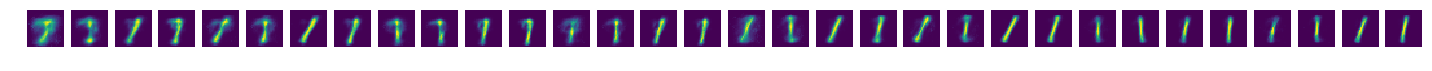

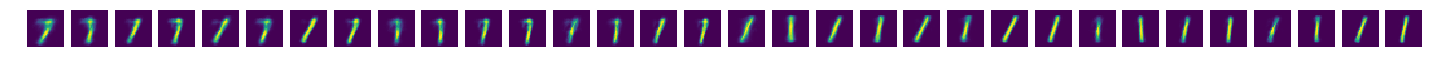

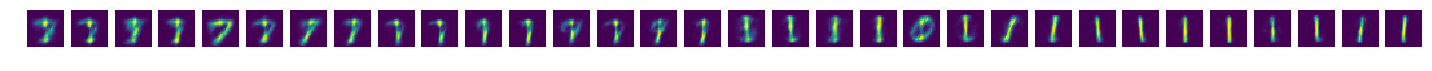

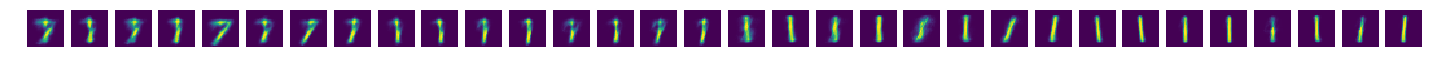

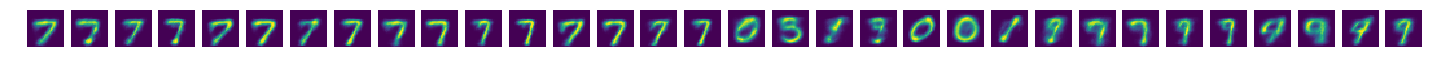

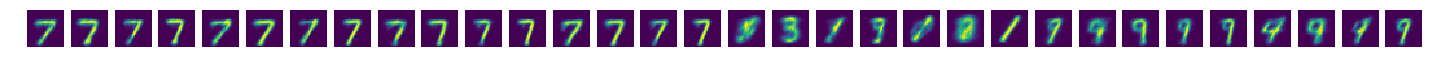

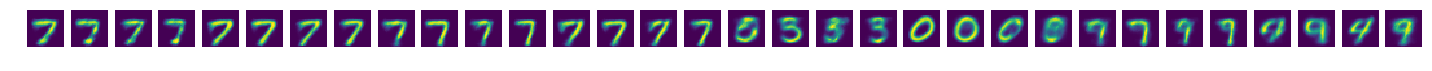

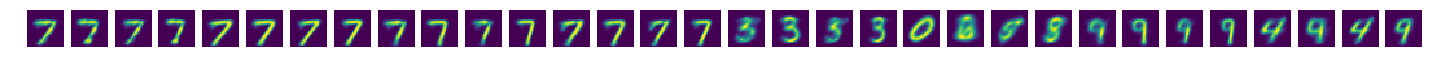

In [43]:
from itertools import product

def debug(start=0, end=32):
    NN = 2**(NUM_LEVELS-1) # `end` is up to NN
    f, axes = plt.subplots(1, end-start, sharey=True, figsize=(25,1))
    k = 0
    kk = 0

    def make_variable(value):
        t = torch.Tensor([value]).type(torch.FloatTensor)
        t = t.unsqueeze(0)
        v = Variable(t)
        if cuda:
            v = v.cuda()
        return v

    for path in product(range(2), repeat=NN):
        if k >= start and k < end:
            decoder_hidden = make_variable(path)
            w = model.D(decoder_hidden)
            ax = axes[kk]
            ax.axis('off')
            #ax.set_title(path)
            ax.imshow(w.view(28,28).cpu().data.numpy())
            kk += 1
        k += 1
    plt.show()
    
for i in range(int(2**(2**(NUM_LEVELS-1))/32)):
    debug(start=i*32, end=(i+1)*32)

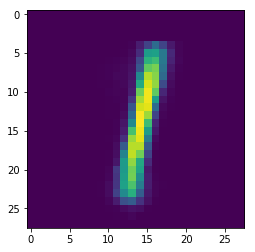

In [114]:
def generate_image():
    sofar = hard_sample_binary_concrete(model.H.root_dist)
    #print(sofar)
    for i in range(len(model.H.downwards)-1, -1, -1):
        sofar = model.H.downwards[i](sofar)
        sofar = hard_sample_binary_concrete(sofar)
        #print(sofar)
    generated = model.D(sofar)
    return generated

generated = generate_image()
generated_img = generated.view(28,28).data.cpu()
plt.imshow(generated_img)

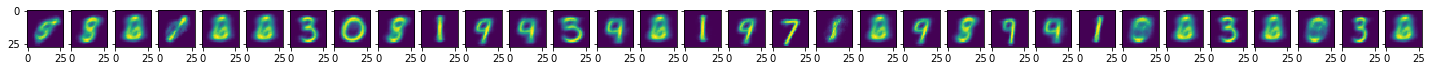

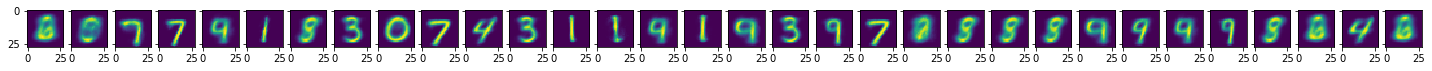

In [134]:
def generate_image_fixed_first_level(value):
    sofar = value#hard_sample_binary_concrete(model.H.root_dist)
    #print(sofar)
    for i in range(len(model.H.downwards)-1, -1, -1):
        sofar = model.H.downwards[i](sofar)
        sofar = hard_sample_binary_concrete(sofar)
        #print(sofar)
    generated = model.D(sofar)
    return generated

f, axes = plt.subplots(1, 32, sharey=True, figsize=(25,1))
for i in range(32):
    value = Variable(torch.Tensor([0]))
    if cuda:
        value = value.cuda()
    generated = generate_image_fixed_first_level(value)
    generated_img = generated.view(28,28).data.cpu()
    ax = axes[i]
    ax.imshow(generated_img)
plt.show()

f, axes = plt.subplots(1, 32, sharey=True, figsize=(25,1))
for i in range(32):
    value = Variable(torch.Tensor([1]))
    if cuda:
        value = value.cuda()
    generated = generate_image_fixed_first_level(value)
    generated_img = generated.view(28,28).data.cpu()
    ax = axes[i]
    ax.imshow(generated_img)
plt.show()